### Tratamento de Dados
Nesta fase, já tendo uma ideia mais concreta do nosso dataset e como os dados estão relacionados entre si e distribuídos, podemos começar por tratá-los da forma que achamos mais correta, justificando. Já temos noção de que não existem missing values, nem duplicados, por isso, centremos a nossa atenção em corrigir o desbalanceamento, nos outliers, feature engeneering, normalização e outros aspetos que consideremos relevantes.


In [70]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.svm import SVC 
from sklearn.metrics import mean_absolute_error, plot_confusion_matrix, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler
import math
from sklearn.metrics import accuracy_score
%matplotlib inline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from pycaret.regression import *
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import (
        mean_absolute_error,
        mean_squared_error,
        mean_squared_log_error,
        r2_score,
)

In [46]:
df = pd.read_csv("../input/Occupancy_Estimation.csv")

### Feature Selection

Para compreender quais as features que realmente importam para o nosso modelo, podemos recorrer à análise da sua correlação manualmente e depois recorrer a *forward selecion*. Compreendemos através do mapa de correlação que as features que medem uma mesma coisa estão muito correlacionadas entre si. Isto pode ser um problema, já que a multicorrelação entre variáveis é um problema para o treino do modelo. Ito é relevante, pois a existência de multicorrelações é prejudicial ao modelo [1]. Analise-se novamente o mapa:

<AxesSubplot: title={'center': 'Correlação entre features'}>

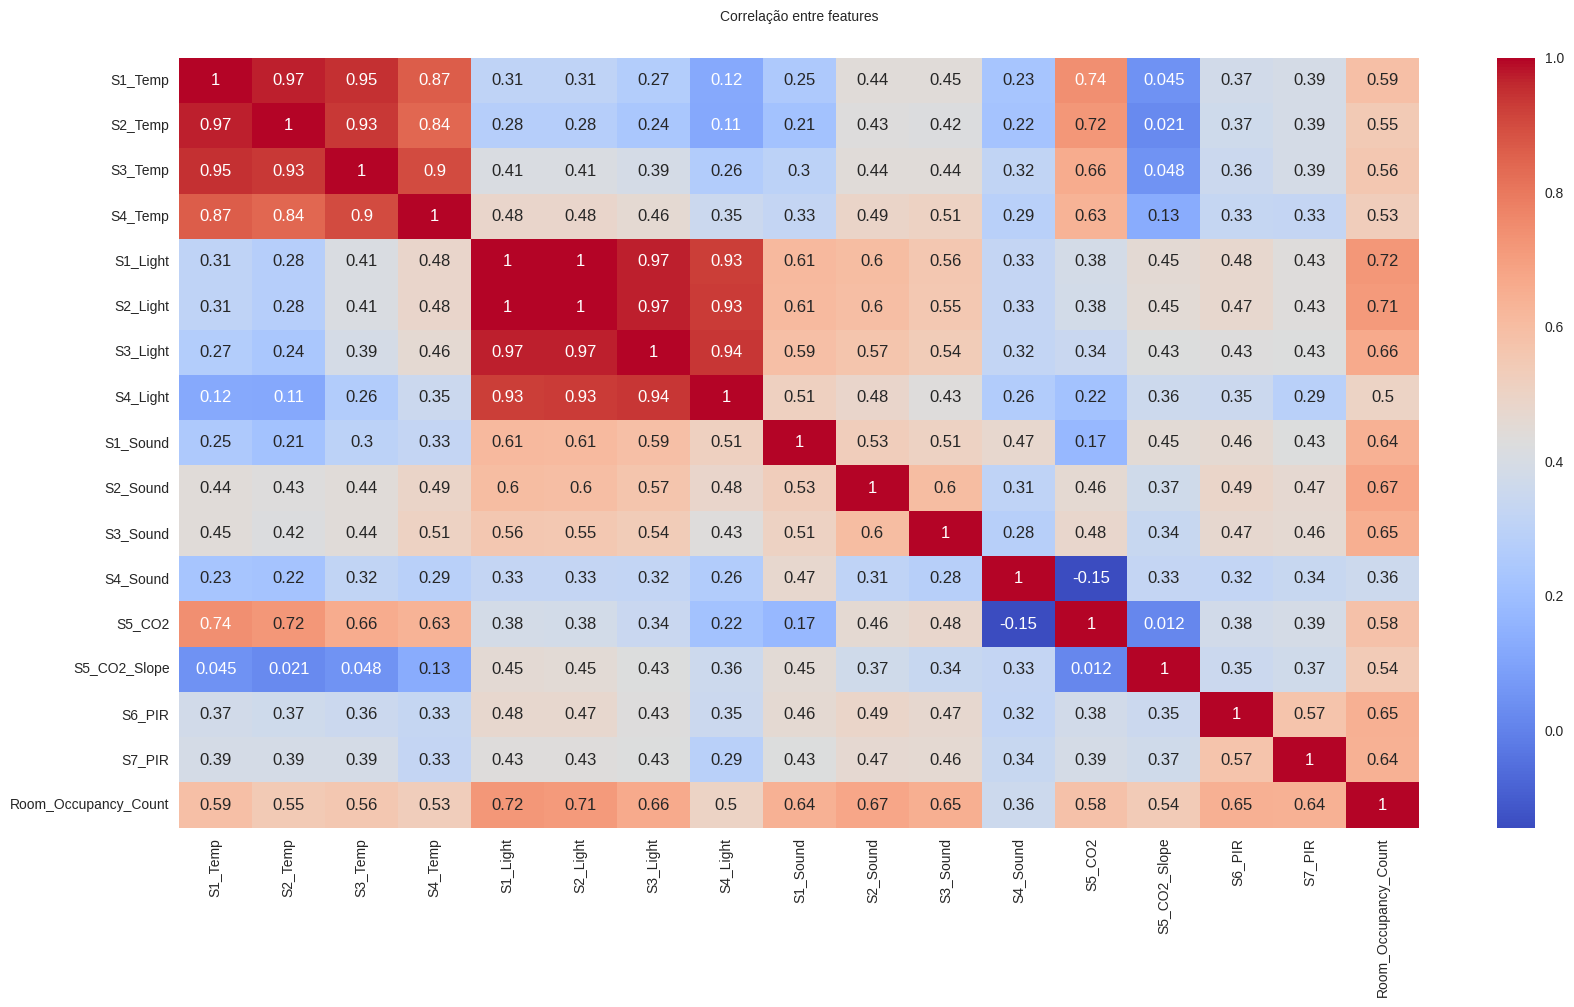

In [47]:
plt.subplots(figsize=(20,10))
plt.title("Correlação entre features", y = 1.03,fontsize = 10, pad = 10)
sns.heatmap(df.corr(method = 'spearman'), annot = True, cmap='coolwarm')

### Correlação entre colunas

Como os dados não seguem uma distribuição normal, não podemos recorrer não método de heatmap de Pearson. Para verificar quais as features a manter, vamos envergar pelo método do teste de hipóteses.

* H0 (hipótese nula): as duas features estão correlacionadas
* HA (hipótese alternativa): as duas features não estão correlacionadas
* Significância = 0.05

In [48]:
## Temperatura
print("Temperatura:\n")
# S1_Temp and S2_Temp
print(stats.spearmanr(df['S1_Temp'], df['S2_Temp']))
# S1_Temp and S3_Temp
print(stats.spearmanr(df['S1_Temp'], df['S3_Temp']))
# S1_Temp and S4_Temp
print(stats.spearmanr(df['S1_Temp'], df['S4_Temp']))
print("-"*50)

## Luz
print("Luz:\n")
# S1_Light and S2_Light
print(stats.spearmanr(df['S1_Light'], df['S2_Light']))
# S1_Light and S3_Light
print(stats.spearmanr(df['S1_Light'], df['S3_Light']))
# S1_Light and S4_Light
print(stats.spearmanr(df['S1_Light'], df['S4_Light']))
print("-"*50)

## Som
print("Som:\n")
# S1_Sound and S2_Sound
print(stats.spearmanr(df['S1_Sound'], df['S2_Sound']))
# S1_Sound and S3_Sound
print(stats.spearmanr(df['S1_Sound'], df['S3_Sound']))
# S1_Sound and S4_Sound
print(stats.spearmanr(df['S1_Sound'], df['S4_Sound']))
print("-"*50)

## CO2
print("CO2:\n")
# S5_CO2 and S5_CO2_Slope
print(stats.spearmanr(df['S5_CO2'], df['S5_CO2_Slope']))
print("-"*50)

## Movimento
print("Movimento:\n")
## S6_PIR and S7_PIR
print(stats.spearmanr(df['S6_PIR'], df['S7_PIR']))
print("-"*50)

Temperatura:

SpearmanrResult(correlation=0.9699286920639255, pvalue=0.0)
SpearmanrResult(correlation=0.9506867426199926, pvalue=0.0)
SpearmanrResult(correlation=0.8651832229542388, pvalue=0.0)
--------------------------------------------------
Luz:

SpearmanrResult(correlation=0.9982857467195643, pvalue=0.0)
SpearmanrResult(correlation=0.9688598268514124, pvalue=0.0)
SpearmanrResult(correlation=0.9280072034816255, pvalue=0.0)
--------------------------------------------------
Som:

SpearmanrResult(correlation=0.5298290733574924, pvalue=0.0)
SpearmanrResult(correlation=0.505002737576469, pvalue=0.0)
SpearmanrResult(correlation=0.47495530859187435, pvalue=0.0)
--------------------------------------------------
CO2:

SpearmanrResult(correlation=0.011713305992435998, pvalue=0.23849518349733714)
--------------------------------------------------
Movimento:

SpearmanrResult(correlation=0.5711250015928457, pvalue=0.0)
--------------------------------------------------


Então:

| **Features**          | **Correlaçao** | **P-value < Significancia (S/N)** | **Rejeitar H0 (S/N)** | **Resultado**       |
|-----------------------|----------------|-----------------------------------|-----------------------|---------------------|
|   S1_Temp & S2_Temp   |      Forte     |                Sim                |          Nao          | **Correlacionados** |
|   S1_Temp & S3_Temp   |      Forte     |                Sim                |          Nao          | **Correlacionados** |
|   S1_Temp & S4_Temp   |      Forte     |                Sim                |          Nao          | **Correlacionados** |
|  S1_Light & S2_Light  |      Forte     |                Sim                |          Nao          | **Correlacionados** |
|  S1_Light & S3_Light  |      Forte     |                Sim                |          Nao          | **Correlacionados** |
|  S1_Light & S4_Light  |      Forte     |                Sim                |          Nao          | **Correlacionados** |
|  S1_Sound & S2_Sound  |      Fraca     |                Sim                |          Nao          | **Correlacionados** |
|  S1_Sound & S3_Sound  |      Fraca     |                Sim                |          Nao          | **Correlacionados** |
|  S1_Sound & S4_Sound  |      Fraca     |                Sim                |          Nao          | **Correlacionados** |
| S5_CO2 & S5_CO2_Slope |      Fraca     |                Sim                |          Nao          | **Correlacionados** |
|    S6_PIR & S7_PIR    |      Fraca     |                Sim                |          Nao          | **Correlacionados** |

Observações:
* As features **S1_Temp**, **S2_Temp**, **S3_Temp** e **S4_Temp** estão muito correlacionadas (>= 0.83), logo, vamos ficar apenas com a coluna **S1_Temp**;
* As features **S1_Light**, **S2_Light**, **S3_Light** e **S4_Light** estão muito correlacionadas (>= 0.93), logo, vamos ficar apenas com a coluna **S1_Light**;
* As features **S1_Sound**, **S2_Sound**, **S3_Sound** e **S4_Sound** estão fracamente correlacionadas (>= 0.035), logo, vamos ficar apenas com a coluna **S1_Sound**;
* As features **S5_CO2** e **S5_CO2_Slope** estão correlacionadas (>= 0.31), logo, vamos ficar apenas com a coluna **S5_CO2**;
* As features **S6_PIR** e **S7_PIR** estão correlacionadas (>= 0.54), logo, vamos ficar apenas com a coluna **S6_PIR**;

[1] https://www.analyticsvidhya.com/blog/2021/03/multicollinearity-in-data-science/

* As features **S1_Temp**, **S1_Light**, **S1_Sound**, **S5_CO2** e **S6_PIR** apresentam mair correlação com o target;

Das condições anteriores, resultam as colunas que devemos manter.

In [49]:
# remover colunas correlacionadas
df = df.drop(columns=['S2_Temp', 'S3_Temp', 'S4_Temp', 
                      'S2_Light', 'S3_Light', 'S4_Light', 
                      'S2_Sound', 'S3_Sound', 'S4_Sound',
                      'S5_CO2_Slope', 'S7_PIR'
                     ])

In [50]:
df.head()

,Date,Time,S1_Temp,S1_Light,S1_Sound,S5_CO2,S6_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,121,0.08,390,0,1
1,2017/12/22,10:50:12,24.94,121,0.93,390,0,1
2,2017/12/22,10:50:42,25.00,121,0.43,390,0,1
3,2017/12/22,10:51:13,25.00,121,0.41,390,0,1
4,2017/12/22,10:51:44,25.00,121,0.18,390,0,1


### Transformação das datas

In [51]:

df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'])
df['day_of_month'] = df['Date'].dt.day
df['week_day'] = df['Date'].dt.weekday
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['hour'] = df['Time'].dt.hour
df['minute'] = df['Time'].dt.minute
# podemos remover as colunas
df.drop('Time', axis=1, inplace=True)
df.drop('Date', axis=1, inplace=True)

In [52]:
df.head()

,S1_Temp,S1_Light,S1_Sound,S5_CO2,S6_PIR,Room_Occupancy_Count,day_of_month,week_day,month,year,hour,minute
0,24.94,121,0.08,390,0,1,22,4,12,2017,10,49
1,24.94,121,0.93,390,0,1,22,4,12,2017,10,50
2,25.00,121,0.43,390,0,1,22,4,12,2017,10,50
3,25.00,121,0.41,390,0,1,22,4,12,2017,10,51
4,25.00,121,0.18,390,0,1,22,4,12,2017,10,51


<AxesSubplot: title={'center': 'Correlação entre features'}>

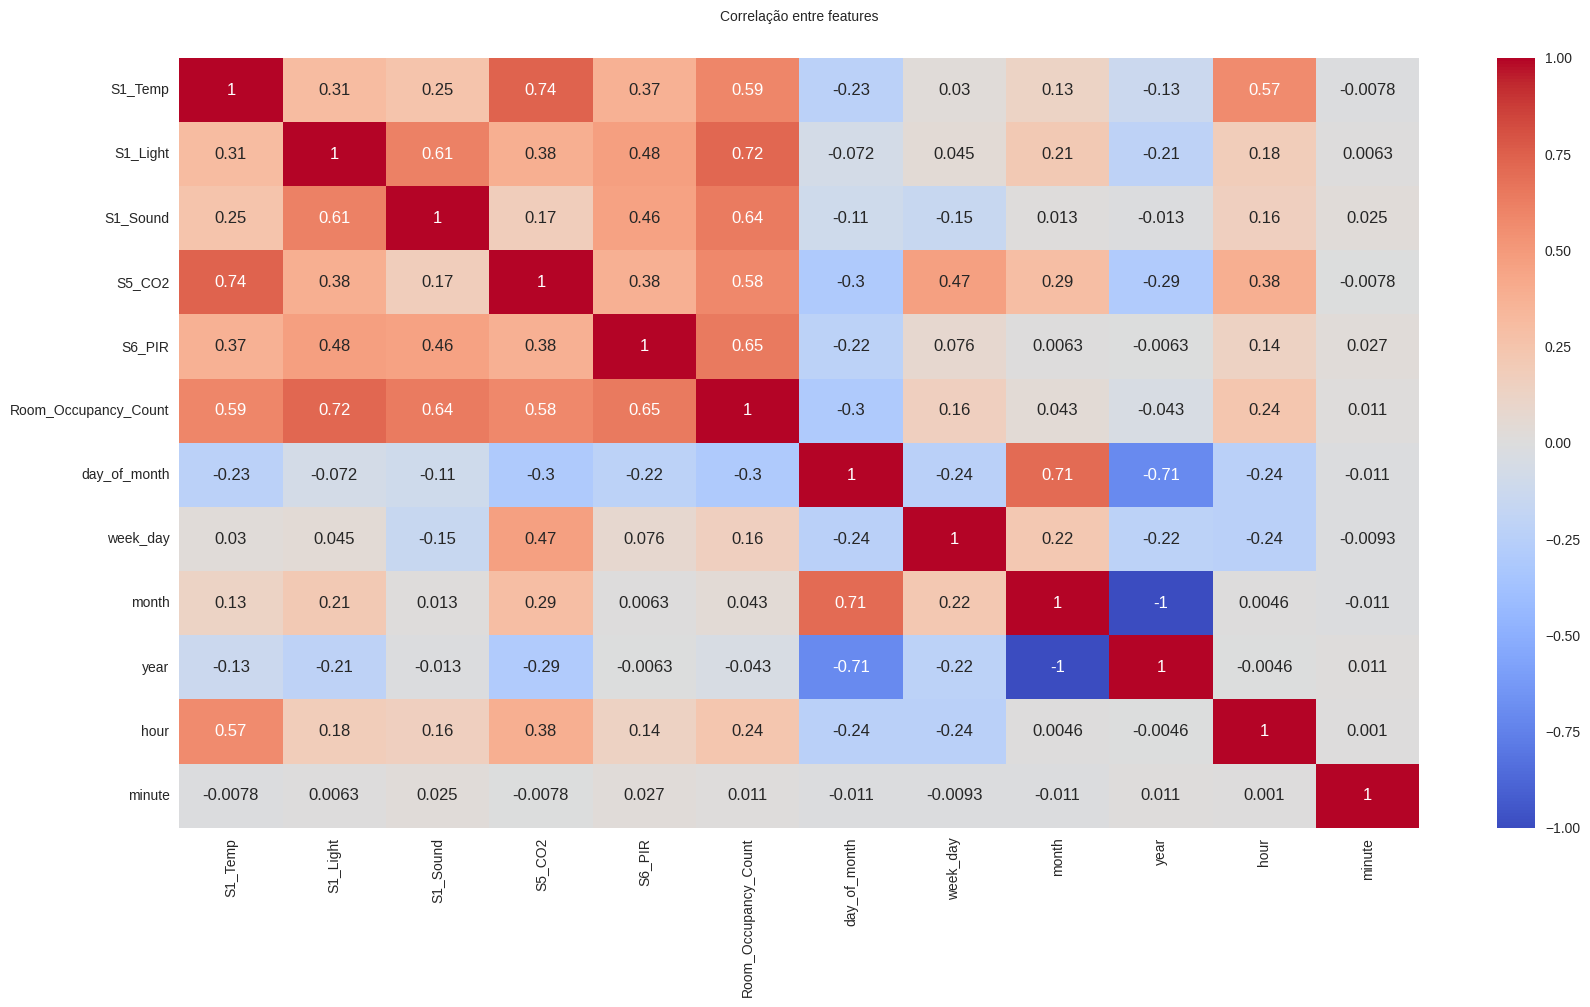

In [53]:
plt.subplots(figsize=(20,10))
plt.title("Correlação entre features", y = 1.03,fontsize = 10, pad = 10)
sns.heatmap(df.corr(method = 'spearman'), annot = True, cmap='coolwarm')

In [54]:
# exportar dataset de cenário 0
df.to_csv("../input/Occupancy_Estimation_cleaned.csv", index=False)

## Modelação

Assim como fizemos para o dataset da competição, vamos recorrer ao PyCaret para perceber os modelos que melhor se adequam.

In [55]:
#divisão do target
x = df.drop(['Room_Occupancy_Count'], axis=1)
y = df['Room_Occupancy_Count']

In [56]:
experiment = setup(df, target='Room_Occupancy_Count')

,Description,Value
0,Session id,946
1,Target,Room_Occupancy_Count
2,Target type,Regression
3,Data shape,"(10129, 12)"
4,Train data shape,"(7090, 12)"
5,Test data shape,"(3039, 12)"
6,Numeric features,11
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


In [57]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0122,0.0040,0.0590,0.9950,0.0246,0.0243,1.8530
et,Extra Trees Regressor,0.0055,0.0047,0.0611,0.9940,0.0245,0.0118,0.0870
rf,Random Forest Regressor,0.0068,0.0050,0.0636,0.9938,0.0280,0.0133,0.1510
xgboost,Extreme Gradient Boosting,0.0066,0.0063,0.0657,0.9921,0.0246,0.0145,0.1300
lightgbm,Light Gradient Boosting Machine,0.0222,0.0099,0.0961,0.9877,0.0499,0.0362,0.0400
dt,Decision Tree Regressor,0.0055,0.0097,0.0832,0.9874,0.0336,0.0117,0.0160
gbr,Gradient Boosting Regressor,0.0277,0.0144,0.1166,0.9823,0.0448,0.0525,0.1230
knn,K Neighbors Regressor,0.0155,0.0174,0.1280,0.9785,0.0608,0.0298,0.0180
ada,AdaBoost Regressor,0.0589,0.0193,0.1374,0.9760,0.0656,0.1224,0.0650
ridge,Ridge Regression,0.2237,0.1668,0.4075,0.7915,0.1989,0.3024,0.0120


Observações:
* Com o tratamento atual, o pycaret diz que os melhores modelos são (Top 2):
    * CatBoost Regressor
    * Decision Tree Regressor
    * RandomForest Regressor (vamos também ver este)
* Então, modelos que usam árvores parecem ter melhor performance, é nesses que nos focaremos para já. 

Como neste caso, há um grande desbalanceamento, para reduzir a probabilidade de overfit, vamos optar pela utilização de Cross-validation na nossa modelação, recorrendo a
StratifiedKFold, uma técnica de validação cruzada.

Por questões de simplicidade, vamos usar apenas modelos da sklearn, compatíveis com cross-validation

## Cenário 0 - Aplicação dos modelos (default) ao dataset tratado
* sem missing values, features numéricas, processamento mínimo de datas

In [59]:
METRICS = {
        "MAE": make_scorer(mean_absolute_error),
        "MSE": make_scorer(mean_squared_error,squared=True),
        "RMSE": make_scorer(mean_squared_error,squared=False),
        "r2_Score": make_scorer(r2_score),
        "RMSLE": make_scorer(mean_squared_log_error,squared=False)
}

X, y = df.drop("Room_Occupancy_Count", axis=1), df["Room_Occupancy_Count"]

## Decision Trees

In [66]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
#Função de kfold com 10 iterações, garante que os resultados são iguais

## DT
dt = DecisionTreeRegressor(max_depth=3, random_state=1234)
scores = cross_validate(dt, X, y, cv=splitter, scoring=METRICS)
dt_scores = pd.DataFrame(scores)
pd.DataFrame(dt_scores.mean()).T

,fit_time,score_time,test_MAE,test_MSE,test_RMSE,test_r2_Score,test_RMSLE
0,0.008152,0.002607,0.060198,0.061134,0.245313,0.923407,0.10839


## Random Forest

In [67]:
rf = RandomForestRegressor(max_depth=3, random_state=1234)
scores = cross_validate(rf, X, y, cv=splitter, scoring=METRICS)
rf_scores = pd.DataFrame(scores)
pd.DataFrame(rf_scores.mean()).T

,fit_time,score_time,test_MAE,test_MSE,test_RMSE,test_r2_Score,test_RMSLE
0,0.436026,0.009631,0.062394,0.056071,0.235008,0.929755,0.103187


## Extra Trees

In [71]:
et = ExtraTreesRegressor(max_depth=3, random_state=1234)
scores = cross_validate(et, X, y, cv=splitter, scoring=METRICS)
et_scores = pd.DataFrame(scores)
pd.DataFrame(et_scores.mean()).T

,fit_time,score_time,test_MAE,test_MSE,test_RMSE,test_r2_Score,test_RMSLE
0,0.189558,0.009823,0.100988,0.087753,0.295433,0.890095,0.127621


Neste momento, temos duas hipóteses:
* Realizamos testes de Feature Selection (no notebook 1.1)
* Seguir para o tratamento dos outliers (no notebook 2)